### Initial playground for domain adaptation and moving into active learning

* Paul Blankley 

In [39]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import pyro

%matplotlib inline

In [27]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    trans = transforms.ToTensor()
    train_set = dset.MNIST(root=root, train=True, transform=trans,
                           download=download)
    test_set = dset.MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

train_loader, test_loader = setup_data_loaders(batch_size=1, use_cuda=False)

In [15]:
# Get the x,y seperation for train
temp_x,temp_y = [],[]
for tx,ty in train_loader:
    temp_x.append(tx)
    temp_y.append(ty)

train_x = torch.cat(temp_x)
train_y = torch.cat(temp_y)

# Get the x,y seperation for test
ttemp_x,ttemp_y = [],[]
for tx,ty in test_loader:
    ttemp_x.append(tx)
    ttemp_y.append(ty)
    
test_x = torch.cat(ttemp_x)
test_y = torch.cat(ttemp_y)

# Accuracy 
def model_eval(model,train_x,train_y,test_x,test_y):
    prob_train = model.forward((Variable(train_x)))
    prob_test = model.forward((Variable(test_x)))
    _,ypred_train = torch.max(prob_train,1)
    _,ypred_test = torch.max(prob_test,1)
    acc_train = (ypred_train.data.numpy()==train_y.numpy()).sum()/len(train_y)
    acc_test = (ypred_test.data.numpy()==test_y.numpy()).sum()/len(test_y)
    return acc_train, acc_test
  

### Idea:

You start with 50 random points to make a model. Then you get to choose 10 points to have the labels given to you.  Just pass a policy function that decides which policy to follow to get the new points.  Then compare the two policies and show that the "active learning" (with intelligent policy performs better).

In [40]:
# Define the model
class logreg(nn.Module):
    """ Logistic regression """
    def __init__(self, classes):
        super(logreg, self).__init__()
        self.classes = classes
        self.w = nn.Linear(28*28,classes)
        
    def forward(self, x):
        x = self.w(x.view(-1,1,28*28))
        return x.view(-1,self.classes)


def train_model(model, data_loader, loss_func, optimizer, epochs=10):
    """ Function to train the model """
    losses,itrs = [],0

    for epoch in tqdm(range(10)):
        for i,(batch_x,batch_y) in enumerate(data_loader):
            batch_x = Variable(batch_x)
            batch_y = Variable(batch_y)

            if i >50:
                break

            y_pred = model(batch_x)
            loss = loss_func(y_pred, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            itrs+=1
            losses.append(loss.data.numpy()[0])
            
    return range(itrs), losses
        
model = logreg(classes=10)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=.01)

plot_itr, plot_loss = train_model(model, train_loader, loss_func, optimizer)

A Jupyter Widget

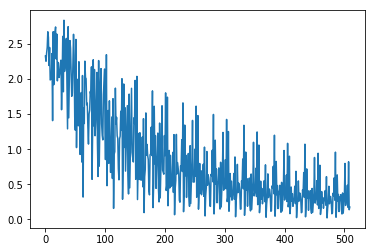

In [36]:
plt.plot(plot_itr,plot_loss)

In [37]:
acc_train, acc_test = model_eval(model,train_x,train_y,test_x,test_y)
print('Accuracy on the train:',acc_train)
print('Accuracy on the test:',acc_test)

Accuracy on the train: 0.642816666667
Accuracy on the test: 0.6369


In [38]:
print(model)

logreg(
  (w): Linear(in_features=784, out_features=10)
)
